<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

In [2]:
X_train = pd.read_csv('../../data/fma_metadata/X_train.csv', index_col=0)
X_validation = pd.read_csv('../../data/fma_metadata/X_validation.csv', index_col=0)
X_train_merged = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train.csv', index_col=0)
y_validation = pd.read_csv('../../data/fma_metadata/y_validation.csv', index_col=0)
y_train_merged = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_validation.shape, X_train_merged.shape, X_test.shape)
print(y_train.shape, y_validation.shape, y_train_merged.shape, y_test.shape)

(82324, 55) (10510, 55) (92834, 55) (10874, 55)
(82324, 1) (10510, 1) (92834, 1) (10874, 1)


In [3]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# validation_n_splits = 8
# test_n_splits = 9
validation_n_splits = 3
test_n_splits = 3

model = DecisionTreeClassifier(random_state=random_state)
model_name = "DecisionTreeClassifier"

cmap = plt.cm.Blues
color = "blue"

In [4]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [5]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


<h1>KNN (baseline classifier)</h1>

KNN (K-Nearest Neighbors) is a type of **instance-based learning** or **non-generalizing learning**: it does not attempt to construct a general internal model, but simply stores instances of the training data.

KNN works best with a dataset that is free of irrelevant and redundant attributes. The former add noise to the proximity measure while the latter introduce bias towards certain attributes. Ultimately, the classifier tends to benefit from dimensionality reduction and variable selection.

Additionally, attributes may need to be resized to prevent distance measurements from being dominated by one of the attributes.

Default parameters:
- n_neighbors=5
- weights='uniform' 
- algorithm='auto'
- leaf_size=30
- p=2
- metric='minkowski'
- metric_params=None 
- n_jobs=None

We proceed by using a grid search in order to identify the optimal values for parameters necessary for the execution of the classification task. The parameters are:

The **number of neighbors**, K:
- a small value for k induces a susceptibility to outliers and noise points;
- a large k makes the classification boundaries less defined;

We decide to analyze a range of sqrt(X)*2 values starting from the closest third neighbor, using only odd ks to preved ties  in the majority vote process(we discarded the nearest neighbour because it can be an outlier and the second nearest neighbours, because they can show a tie). 

The **proximity metric**, used to calculate the distance between the points under analysis. In general it can be any metric measure, the standard Euclidean distance tends to be the most common choice but we decide to add other derivatives of the Minkowski Distance to the research:
- Euclidean distance (Minkowski Distance with p=2)
- Manhattan distance (Minkowski Distance with p=1)

The **weight function** used when classifying unknown points, the method of using the class labels of the nearest neighbors K to determine the class label of the new record. The neighbors can contribute by:
- a majority vote
- by weighting the vote according to their distance from the new record

In [6]:
def model_grid(X_tr):
    grid = dict()
    grid['model__criterion'] = ['gini', 'entropy']
    grid['model__max_features'] = [None, 'auto', 'sqrt', 'log2']
    grid['model__max_depth'] = [None] + list(np.arange(1, len(X_tr.columns) + 1))
    # grid['model__min_samples_split'] = [0.1, 0.01, 0.001] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_split'] = [2, 5] + list(range(10, 101, 10))
    # grid['model__min_samples_split'] = list(np.arange(2, 101))
    # grid['model__min_samples_leaf'] = [0.05, 0.005, 0.0005] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_leaf'] = [2, 5] + list(range(10, 101, 10))
    # grid['model__min_samples_leaf'] = list(np.arange(2, 101))
    grid['model__class_weight'] = ['balanced', None]
    return grid

In [7]:
def model_baseline_classification(X_tr, y_tr, X_ts, y_ts):
    fitted_model = model.fit(X_tr, y_tr.values.ravel())
    y_pred = model.predict(X_ts)
    
    print(confusion_matrix(y_ts, y_pred))
    print(classification_report(y_ts, y_pred))
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.feature_importances_),reverse=True)
        # print(features_importance)
    except:
        pass
    
    try:
        features_importance = sorted(zip(X_tr.columns, fitted_model.coef_),reverse=True)
        # print(features_importance)
    except:
        pass

<h6>All features (categorica, ordinal and continous)</h6>

In [8]:
model_baseline_classification(X_train, 
                              y_train, 
                              X_validation, 
                              y_validation)

[[9037  603]
 [ 424  446]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      9640
           1       0.43      0.51      0.46       870

    accuracy                           0.90     10510
   macro avg       0.69      0.73      0.71     10510
weighted avg       0.91      0.90      0.91     10510



In [9]:
model_baseline_classification(X_train_merged, 
                              y_train_merged, 
                              X_test, 
                              y_test)

[[9176  618]
 [ 571  509]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9794
           1       0.45      0.47      0.46      1080

    accuracy                           0.89     10874
   macro avg       0.70      0.70      0.70     10874
weighted avg       0.89      0.89      0.89     10874



<h6>Only continous variables</h6>

In [10]:
model_baseline_classification(X_train[numeric_columns], 
                              y_train, 
                              X_validation[numeric_columns], 
                              y_validation)

[[8964  676]
 [ 473  397]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9640
           1       0.37      0.46      0.41       870

    accuracy                           0.89     10510
   macro avg       0.66      0.69      0.67     10510
weighted avg       0.90      0.89      0.90     10510



In [11]:
model_baseline_classification(X_train_merged[numeric_columns], 
                              y_train_merged, 
                              X_test[numeric_columns], 
                              y_test)

[[9037  757]
 [ 645  435]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      9794
           1       0.36      0.40      0.38      1080

    accuracy                           0.87     10874
   macro avg       0.65      0.66      0.66     10874
weighted avg       0.88      0.87      0.87     10874



<h6>Only categorical or ordinal variables</h6>

In [12]:
model_baseline_classification(X_train[categoric_columns], 
                              y_train, X_validation[categoric_columns], 
                              y_validation)

[[9520  120]
 [ 651  219]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      9640
           1       0.65      0.25      0.36       870

    accuracy                           0.93     10510
   macro avg       0.79      0.62      0.66     10510
weighted avg       0.91      0.93      0.91     10510



In [13]:
model_baseline_classification(X_train_merged[categoric_columns], 
                              y_train_merged, 
                              X_test[categoric_columns], 
                              y_test)

[[9645  149]
 [ 962  118]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9794
           1       0.44      0.11      0.18      1080

    accuracy                           0.90     10874
   macro avg       0.68      0.55      0.56     10874
weighted avg       0.86      0.90      0.87     10874



<font color="red"> <h1> Dimensionality reduction</h1></font>

Dimensionality reduction refers to techniques that reduce the number of input variables in a
dataset. More input features often make a predictive modeling task more challenging to model,
more generally referred to as the **curse of dimensionality**.

Dimensionality reduction methods include:
- feature selection: use scoring or statistical methods to select which features to keep and which features to delete:
    - **Wrapper methods**, wrap a machine learning model, fitting and evaluating the model with different subsets 
      input features and selecting the subset the results in the best model performance. (i.e. RFE);
    - **Filter methods** use scoring methods between the feature and the target variable, to select a
      subset of input features that are most predictive (i.e. Pearson’s correlation or Chi-Squared test).
- linear algebra methods:
    - **Matrix Factorization**: feature matrix (i.e. covariance matrix) can  be ranked and a subset of those parts can       be selected that best captures the salient structure of thematrix that can be used to represent the dataset.       (i.e. PCA);
- projection methods / manifold learning and are used to create a low-dimensional projection of high-dimensional data, whilst best preserving the salient structure or relationships in the data (i.e. SOM);
- autoencoders: A nueral network model is used that seeks to compress the data flow to a bottleneck layer with far fewer dimensions than the original input data. The part of the model prior to and including the bottleneck is referred to as the encoder, and the part of the model that reads the bottleneck output and reconstructs the input is called the decoder.

<u>Typically, linear algebra and manifold learning methods
assume that all input features have the same scale or distribution. This suggests that it is
good practice to either normalize or standardize data prior to using these methods.</u>

<b><font color="green"> 
For our feature selection process we decided to first use the Pearson Correlation Method to remove highly correlated features (see Features_Data_Understandind.ipynb);
Since data dimensionality was still high, we evaluate three different roads:
- Univariate Method, using SelectKBest with the ANOVA F-test, since our continous variables are almost alway normal distributed, while our classification target is categorical;
- Feature Importance Method, using RFE with features ranked according to feature_importances_ or coef_ derived from a DecisionTreeClassifier() and a LogisticRegression(), respectively;
- Variance Threshold, removing features whose variance doesn’t meet a threshold equalt to 0.01
</font></b>

<h2>ANOVA feature selection (filter method)</h2>

<u> Importantly, ANOVA is used when one variable is numeric and one is categorical, such as
numerical input variables and a classification target variable in a classification task.</u>

ANOVA is an acronym for analysis of variance and is a parametric statistical hypothesis test for
determining whether the means from two or more samples of data (often three or more) come
from the same distribution or not. An F-statistic, or F-test, is a class of statistical tests that
calculate the ratio between variances values, such as the variance from two different samples or
the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method
is a type of F-statistic referred to here as an **ANOVA F-test**.


The scikit-learn machine library provides an implementation of the ANOVA F-test in the
f **classif()** function. This function can be used in a feature selection strategy, such as selecting
the top k most relevant features (largest values) via the **SelectKBest** class.


We cawilln systematically test a range
of different numbers of selected features and discover which results in the best performing
model. This is called a grid search, where the k argument to the SelectKBest class can be
tuned. It is good practice to evaluate model configurations on classification tasks using repeated
stratified k-fold cross-validation. We will use **3-fold cross-validation** via the
**StratifiedKFold** class.

**Since both class labels are equally important and we assign equl cost to FN and FP, we will use as GridSearch's scoring metric the f1_weighted measure** (we want a trade-off among precision and recall).

N.B. 
- f1_macro => unweighted class label
- f1_weighted => weighted class label

In [14]:
def get_best_features_grid_cv(X_tr, y_tr, v_or_t_flag, results, key):
    best_k = results.best_params_[key]
    if key == 'anova__k':
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe__n_features_to_select':
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # plot feature importance
    fig = plt.figure(figsize=(8, 10))
    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                            order=ordered_k_feature_scores.features)
    plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.split('__')[0].upper()))
    plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [15]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob, v_or_t_flag):
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob, v_or_t_flag):
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob, v_or_t_flag):
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob, v_or_t_flag):
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize, v_or_t_flag):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name.capitalize(), v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred, v_or_t_flag):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model, v_or_t_flag):
    pca = PCA(n_components=2)
    best_visualisation_scaler = StandardScaler()
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
    plt.legend(loc='best')
    plt.show()

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred, v_or_t_flag):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, v_or_t_flag, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()

In [16]:
def dt(X_tr, y_tr, X_ts, y_ts, grid, params, v_or_t_flag):
    
    model_params = list(grid.keys())
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params.keys())
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  DecisionTreeClassifier(**model_hyperparameters, random_state=random_state)
    
    # perform classification
    tuned_model = tuned_model.fit(X_tr, y_tr.values.ravel())
    y_pred = tuned_model.predict(X_ts)
    y_prob = tuned_model.predict_proba(X_ts)
    
    # plots
    # best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, model, v_or_t_flag)
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, tuned_model.classes_, True, v_or_t_flag)
    plot_classification_report(y_ts, y_pred, v_or_t_flag)
    
    plot_roc_curve(y_ts, y_prob, v_or_t_flag)
    plot_precision_recall_curve(y_ts, y_prob, v_or_t_flag)
    plot_cumulative_gain_curve(y_ts, y_prob, v_or_t_flag)
    plot_lift_curve_curve(y_ts, y_prob, v_or_t_flag)
    
    plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model, v_or_t_flag)  # passing random scaler
    # plot_learning_curve(X_tr, y_tr, model, v_or_t_flag)
    # error_visualizer(not_scale_X_ts, y_ts, y_pred, v_or_t_flag, 'chroma_cens_02', 'track_duration')
    
    # return tuned_model, y_pred, y_prob, best_features, best_features_scores
    return tuned_model, y_pred, y_prob

In [17]:
from scipy.stats import boxcox, shapiro, yeojohnson

def anova_feature_reduction(X_tr, y_tr, grid, scaler_flag, v_or_t_flag):
    
    # define the evaluation method
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
    elif v_or_t_flag == 'TST':
         cv = StratifiedKFold(n_splits=test_n_splits)
    else:
        print("v_or_t_flag error")
        sys.exit(-1)

    # define the pipeline to evaluate
    # scaler = RobustScaler()
    anova = SelectKBest(score_func=f_classif)
    
    if scaler_flag:
        pipeline = Pipeline(steps=[('scaler', None), ('anova', anova), ('model', model)])
        grid['scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
    else:
        pipeline = Pipeline(steps=[('anova', anova), ('model', model)])

    # define the grid to search:
    grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=False, random_state=random_state)
    
    # perform the search
    # normalized data
    X_tr_norm = X_tr.apply(lambda x: yeojohnson(x)[0])
    # perform the search
    results = search.fit(X_tr_norm, y_tr.values.ravel())

    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, v_or_t_flag, results, 'anova__k')
    
    return results, params, best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.738 
Best Config: {'model__min_samples_split': 30, 'model__min_samples_leaf': 90, 'model__max_features': 'sqrt', 'model__max_depth': 7, 'model__criterion': 'entropy', 'model__class_weight': None, 'anova__k': 50} 


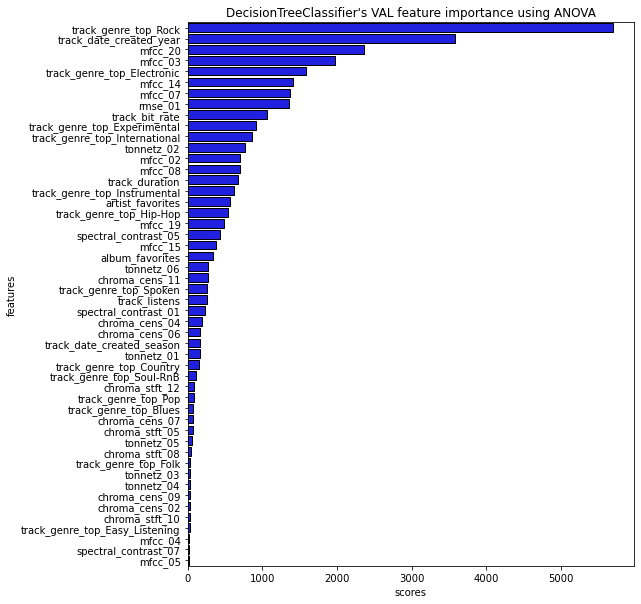

In [18]:
anova_results_val, anova_params_val, anova_best_features_val, anova_best_features_scores_val = \
                                anova_feature_reduction(
                                                        X_tr=X_train, 
                                                        y_tr=y_train, 
                                                        grid=model_grid(X_train), 
                                                        scaler_flag=False, 
                                                        v_or_t_flag='VAL')

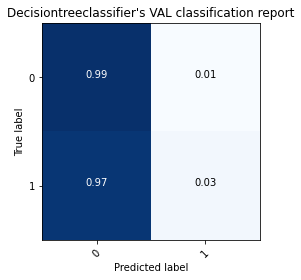

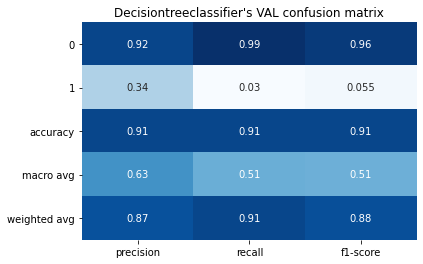

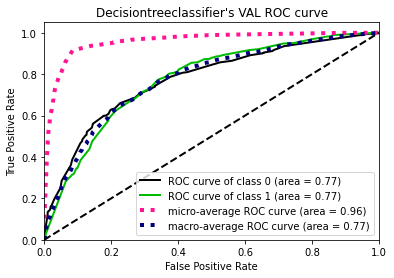

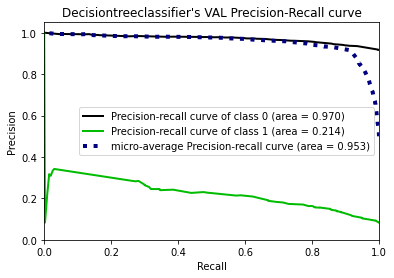

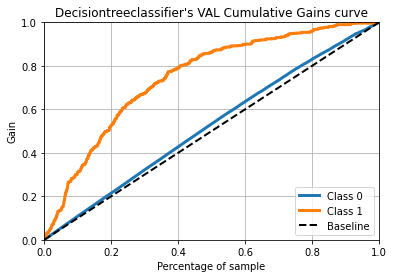

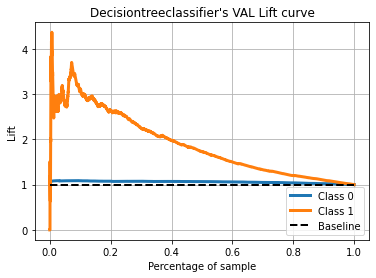

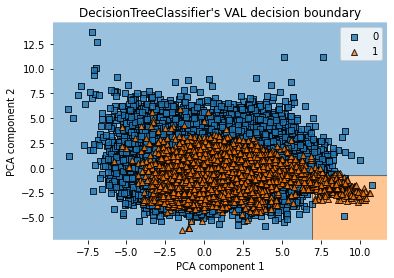

In [19]:
anova_tuned_model_val, anova_y_pred_val, anova_y_prob_val = dt(
                                            X_tr=X_train[anova_best_features_val], 
                                            y_tr=y_train, 
                                            X_ts=X_validation[anova_best_features_val], 
                                            y_ts=y_validation, 
                                            grid=model_grid(X_train[anova_best_features_val]), 
                                            params=anova_params_val, 
                                            v_or_t_flag='VAL')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.679 
Best Config: {'model__min_samples_split': 90, 'model__min_samples_leaf': 70, 'model__max_features': 'sqrt', 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'anova__k': 49} 


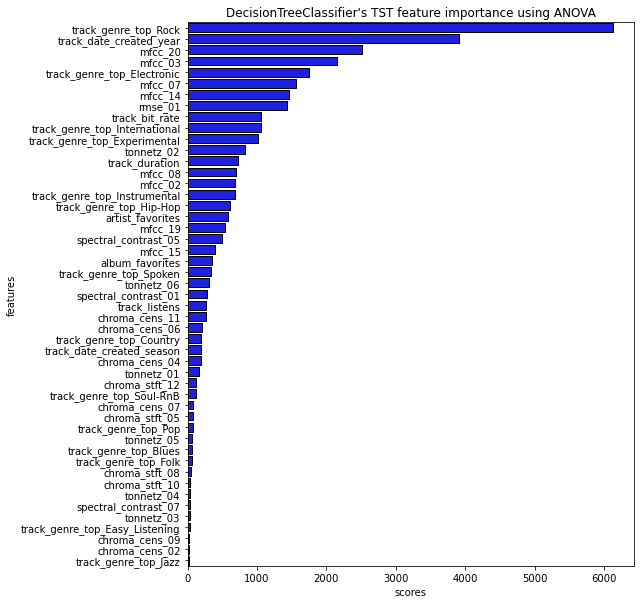

In [20]:
anova_results_tst, anova_params_tst, anova_best_features_tst, anova_best_features_scores_tst = \
                                anova_feature_reduction(
                                                        X_tr=X_train_merged, 
                                                        y_tr=y_train_merged, 
                                                        grid=model_grid(X_train_merged), 
                                                        scaler_flag=False, 
                                                        v_or_t_flag='TST')

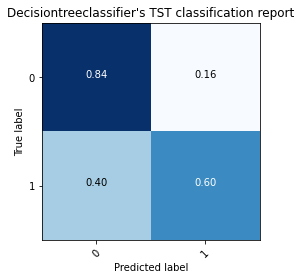

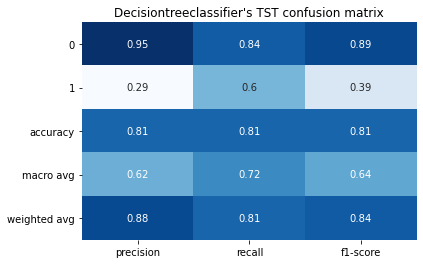

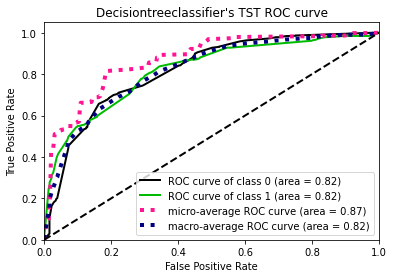

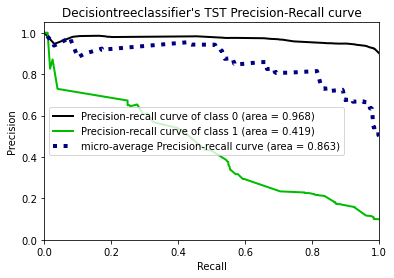

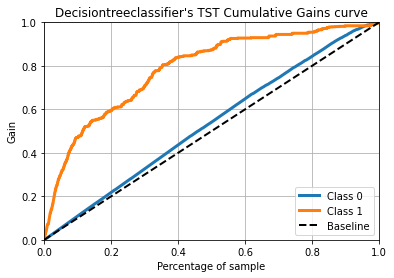

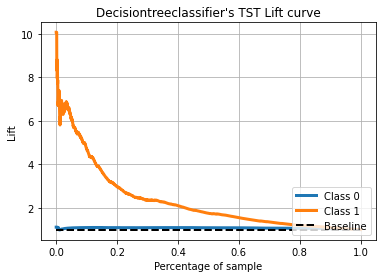

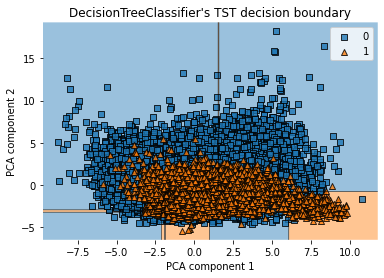

In [21]:
anova_tuned_model_tst, anova_y_pred_tst, anova_y_prob_tst = dt(
                                            X_tr=X_train_merged[anova_best_features_tst], 
                                            y_tr=y_train_merged, 
                                            X_ts=X_test[anova_best_features_tst], 
                                            y_ts=y_test, 
                                            grid=model_grid(X_train_merged[anova_best_features_tst]), 
                                            params=anova_params_tst, 
                                            v_or_t_flag='TST')

<h2>RFE (Recursive Feature Elimination) (wrapper method)</h2>

The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

RFE **requires a nested algorithm that is used to provide the feature importance scores**, such
as a decision tree (**feature_importances_ attribute**) or a linear model(**coef_ attribute**).

Feature importance refers to techniques that assign a score to input features based on how
useful they are at predicting a target variable:
- statistical correlation scores;
- coefficients calculated as part of linear models or decision trees;
- permutation importance scores.

<u> RFECV automatic select best k number of features </h6>

In [22]:
def rfe_feature_reduction(X_tr, y_tr, grid, scaler_flag, v_or_t_flag):
    
    # define the evaluation method
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
    elif v_or_t_flag == 'TST':
         cv = StratifiedKFold(n_splits=test_n_splits)
    else:
        print("v_or_t_flag error")
        sys.exit(-1)

    # define the pipeline to evaluate
    # scaler = RobustScaler()
    rfe = RFE(estimator=DecisionTreeClassifier())
    
    if scaler_flag:
        pipeline = Pipeline(steps=[('scaler', None), ('rfe', rfe), ('model', model)])
        grid['scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
    else:
        pipeline = Pipeline(steps=[('rfe', rfe), ('model', model)])

    # define the grid to search:
    """grid['rfe__estimator'] = [DecisionTreeClassifier(), RandomForestClassifier(), Perceptron(),
                                   LogisticRegression(), GradientBoostingClassifier()]"""
    grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
    grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=False, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())

    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    best_features, best_features_scores = get_best_features_grid_cv(X_tr, y_tr, v_or_t_flag, results, 
                                                                                    'rfe__n_features_to_select')
    
    return results, params, best_features, best_features_scores

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.860 
Best Config: {'rfe__n_features_to_select': 31, 'rfe__estimator': LogisticRegression(max_iter=10000), 'model__min_samples_split': 20, 'model__min_samples_leaf': 100, 'model__max_features': None, 'model__max_depth': 28, 'model__criterion': 'entropy', 'model__class_weight': None} 


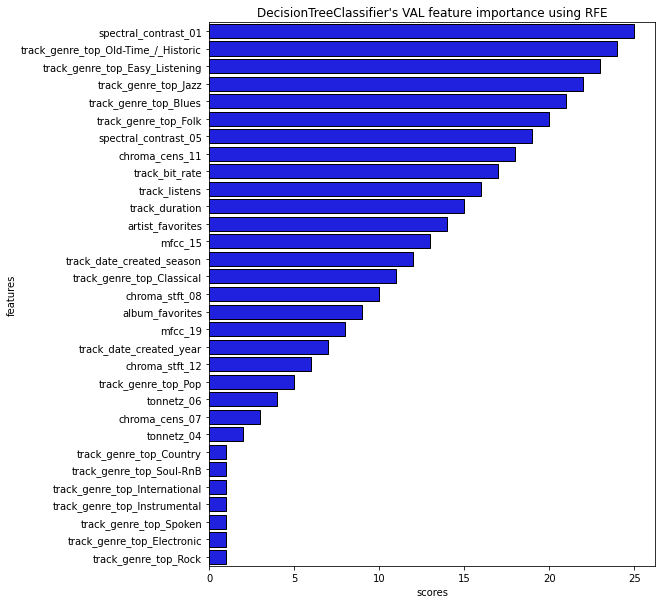

In [23]:
rfe_results_val, rfe_params_val, rfe_best_features_val, rfe_best_features_scores_val = \
                                    rfe_feature_reduction(
                                                            X_tr=X_train, 
                                                            y_tr=y_train, 
                                                            grid=model_grid(X_train), 
                                                            scaler_flag=False, 
                                                            v_or_t_flag='VAL')

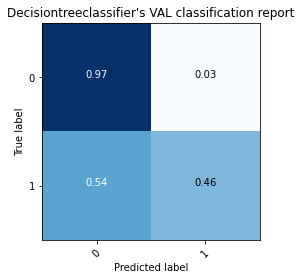

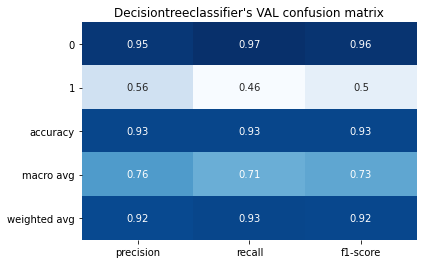

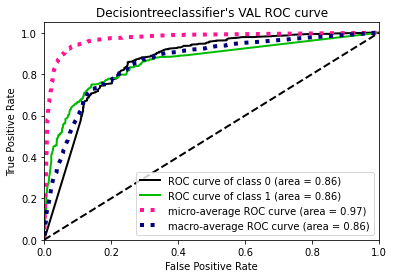

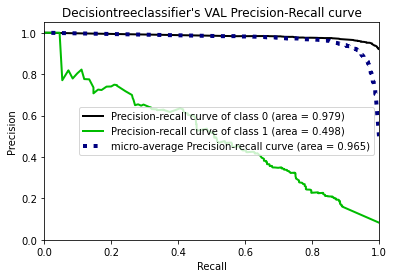

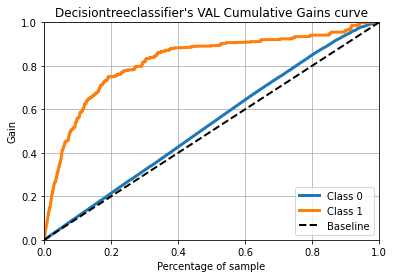

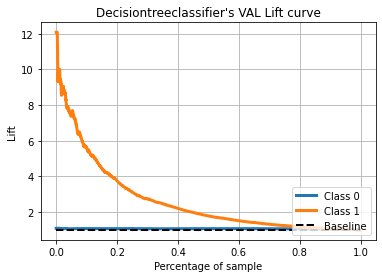

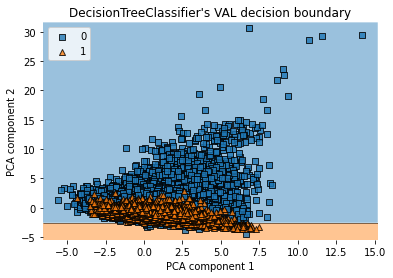

In [24]:
rfe_tuned_model_val, rfe_y_pred_val, rfe_y_prob_val = dt(
                                            X_tr=X_train[rfe_best_features_val], 
                                            y_tr=y_train, 
                                            X_ts=X_validation[rfe_best_features_val], 
                                            y_ts=y_validation, 
                                            grid=model_grid(X_train[rfe_best_features_val]), 
                                            params=rfe_params_val, 
                                            v_or_t_flag='VAL')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.862 
Best Config: {'rfe__n_features_to_select': 31, 'rfe__estimator': LogisticRegression(max_iter=10000), 'model__min_samples_split': 20, 'model__min_samples_leaf': 100, 'model__max_features': None, 'model__max_depth': 28, 'model__criterion': 'entropy', 'model__class_weight': None} 


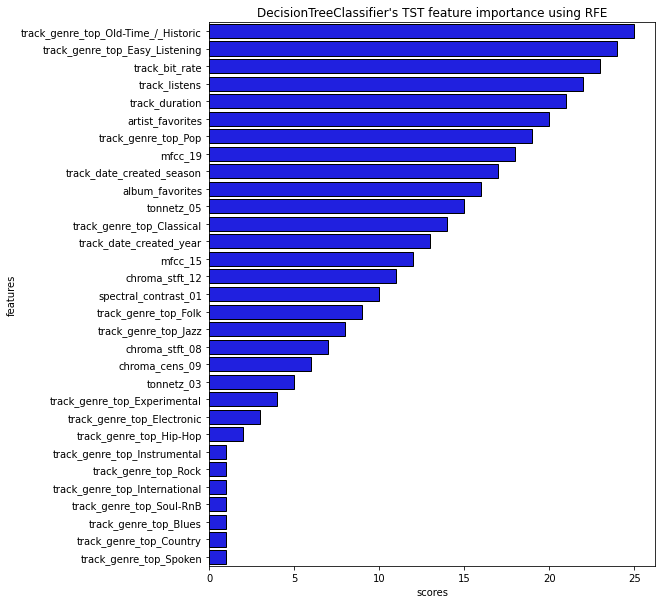

In [25]:
rfe_results_tst, rfe_params_tst, rfe_best_features_tst, rfe_best_features_scores_tst = \
                                    rfe_feature_reduction(
                                                            X_tr=X_train_merged, 
                                                            y_tr=y_train_merged, 
                                                            grid=model_grid(X_train_merged), 
                                                            scaler_flag=False, 
                                                            v_or_t_flag='TST')

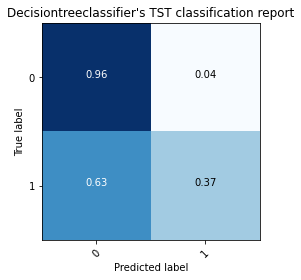

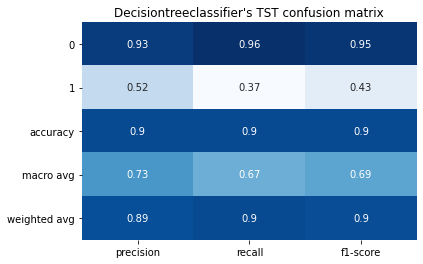

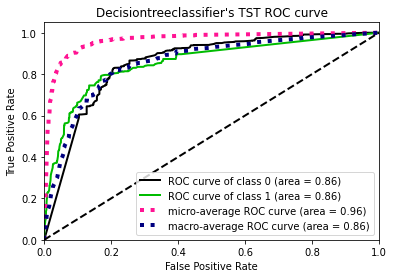

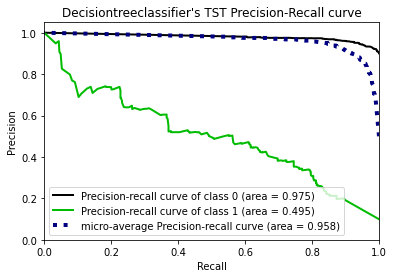

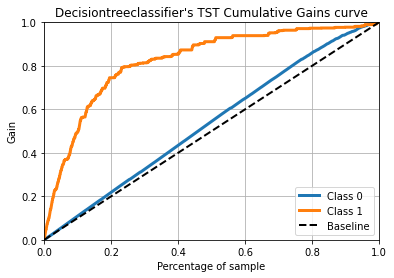

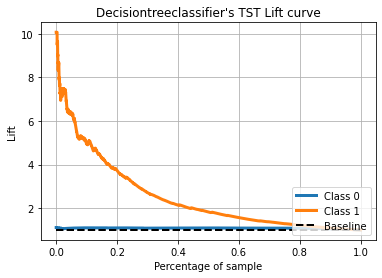

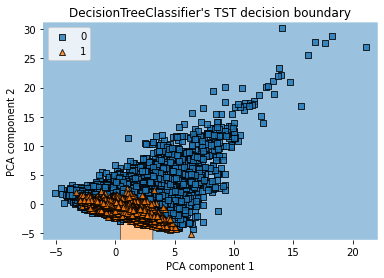

In [26]:
rfe_tuned_model_tst, rfe_y_pred_tst, rfe_y_prob_tst = dt(
                                            X_tr=X_train_merged[rfe_best_features_tst], 
                                            y_tr=y_train_merged, 
                                            X_ts=X_test[rfe_best_features_tst], 
                                            y_ts=y_test, 
                                            grid=model_grid(X_train_merged[rfe_best_features_tst]), 
                                            params=rfe_params_tst, 
                                            v_or_t_flag='TST')

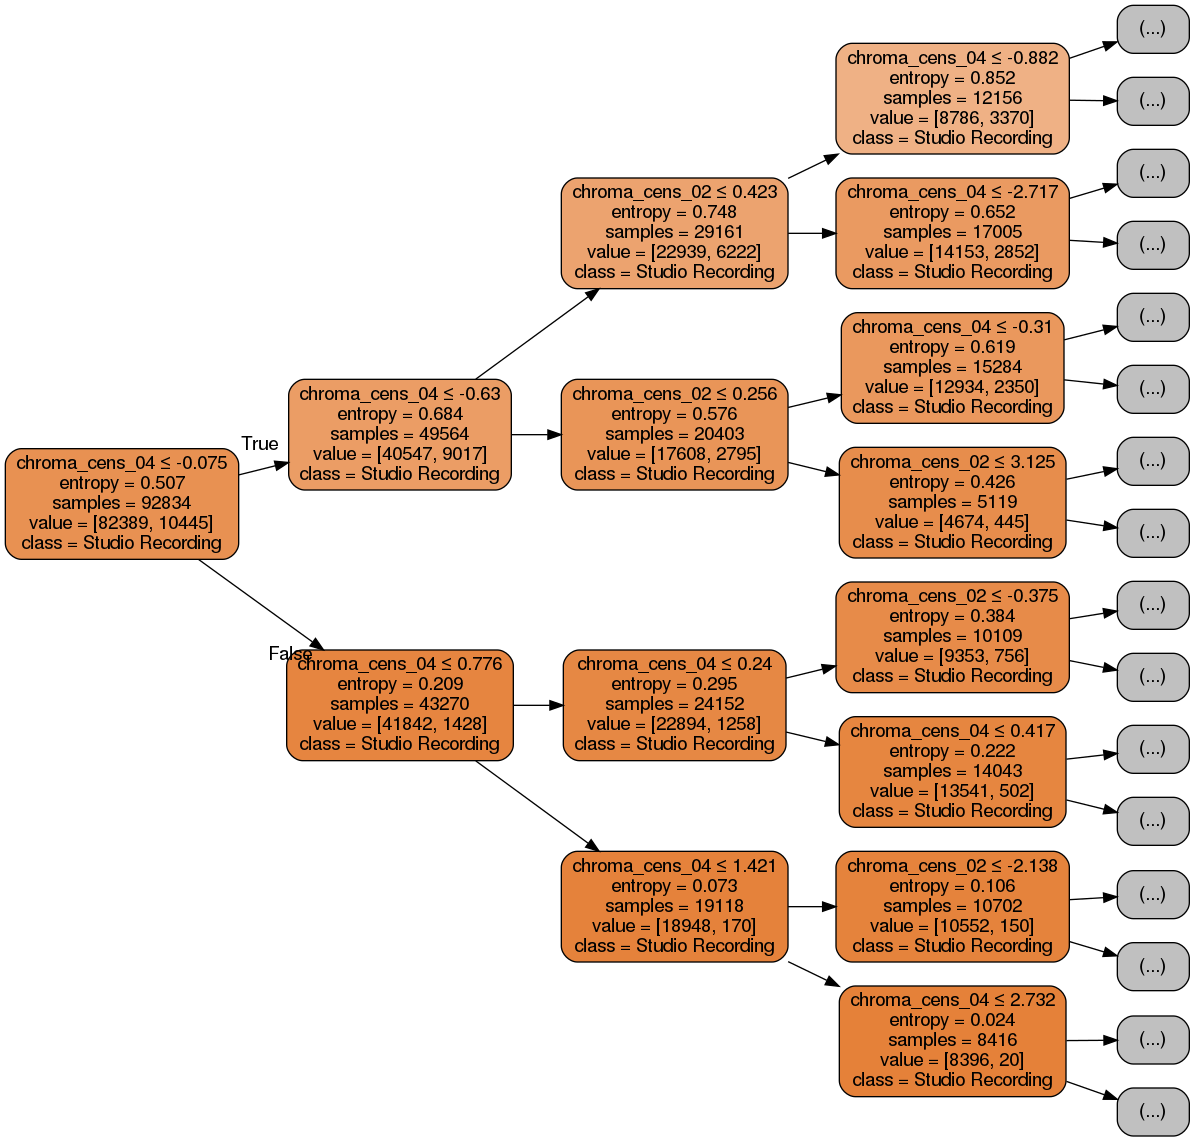

In [27]:
# draw best model's decision tree
class_names = rfe_tuned_model_tst.classes_
feature_names = X_train.columns[class_names]

dot_data = tree.export_graphviz(rfe_tuned_model_tst, out_file=None,
                            feature_names=feature_names,
                            # feature_names=list(X_train_merged.columns),
                            class_names=['Live Recoding' if x == 1 
                                         else 'Studio Recording' for x in rfe_tuned_model_tst.classes_],
                            filled=True, 
                            rounded=True, 
                            rotate=True,
                            special_characters=True,
                            max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

<h2>Variance Threshold</h2>

In [28]:
X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_vt.csv', index_col=0)
X_validation_vt = pd.read_csv('../../data/fma_metadata/X_validation_vt.csv', index_col=0)
X_train_merged_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_validation_vt.shape, X_train_merged_vt.shape, X_test_vt.shape)
print(y_train.shape, y_validation.shape, y_train_merged.shape, y_test.shape)

(82324, 28) (10510, 28) (92834, 28) (10874, 28)
(82324, 1) (10510, 1) (92834, 1) (10874, 1)


In [29]:
numeric_columns_vt = set(numeric_columns).intersection(set(X_train_vt.columns))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [30]:
categoric_columns_vt = set(categoric_columns).intersection(set(X_train_vt.columns))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


In [31]:
def grid_search(X_tr, y_tr, grid, scaler_flag, v_or_t_flag):
    
    # define the evaluation method
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
    elif v_or_t_flag == 'TST':
         cv = StratifiedKFold(n_splits=test_n_splits)
    else:
        print("v_or_t_flag error")
        sys.exit(-1)

    # define the pipeline to evaluate
    # scaler = RobustScaler()
    if scaler_flag:
        pipeline = Pipeline(steps=[('scaler', None), ('model', model)])
        grid['scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
    else:
        pipeline = Pipeline(steps=[('model', model)])
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=False, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())

    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    return results, params

In [32]:
vt_results_val, vt_params_val = grid_search(
                                X_tr=X_train_vt, 
                                y_tr=y_train, 
                                grid=model_grid(X_train_vt), 
                                scaler_flag=False, 
                                v_or_t_flag='VAL')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.810 
Best Config: {'model__min_samples_split': 90, 'model__min_samples_leaf': 5, 'model__max_features': 'auto', 'model__max_depth': 8, 'model__criterion': 'entropy', 'model__class_weight': None} 


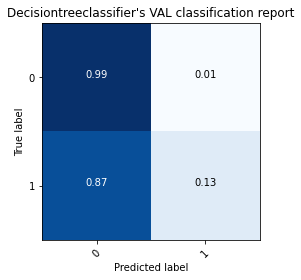

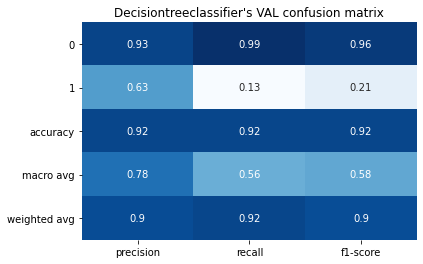

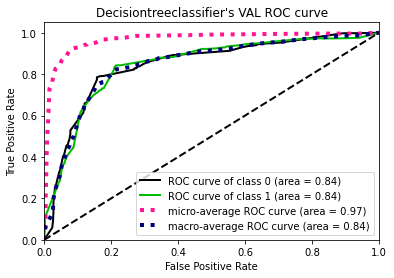

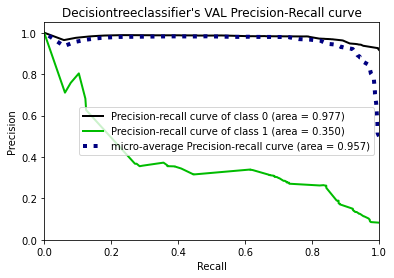

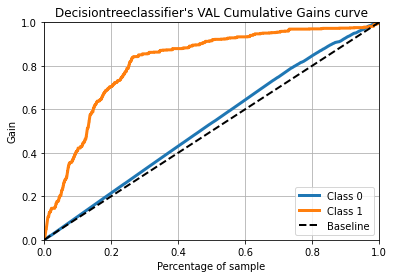

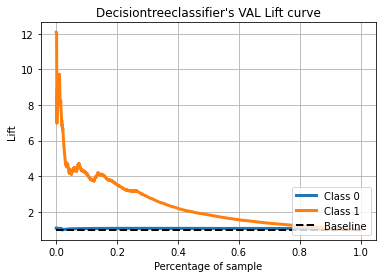

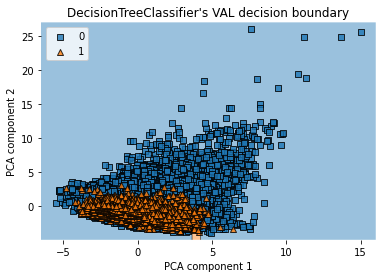

In [33]:
vt_tuned_model_val, vt_y_pred_val, vt_y_prob_val = dt(
                                            X_tr=X_train_vt, 
                                            y_tr=y_train, 
                                            X_ts=X_validation_vt, 
                                            y_ts=y_validation, 
                                            grid=model_grid(X_train_vt), 
                                            params=vt_params_val, 
                                            v_or_t_flag='VAL')

In [34]:
vt_results_tst, vt_params_tst = grid_search(
                                X_tr=X_train_merged_vt, 
                                y_tr=y_train_merged, 
                                grid=model_grid(X_train_merged_vt), 
                                scaler_flag=False, 
                                v_or_t_flag='TST')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.762 
Best Config: {'model__min_samples_split': 50, 'model__min_samples_leaf': 20, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'gini', 'model__class_weight': None} 


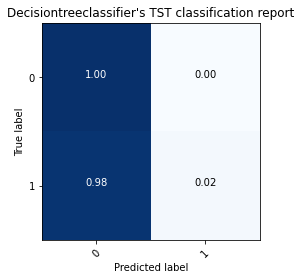

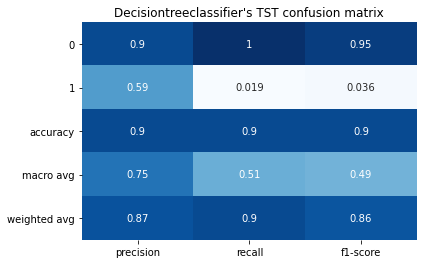

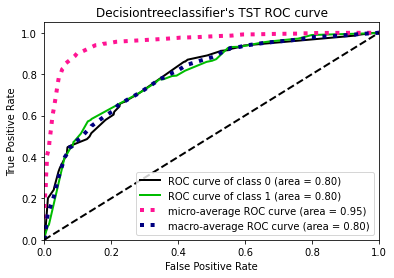

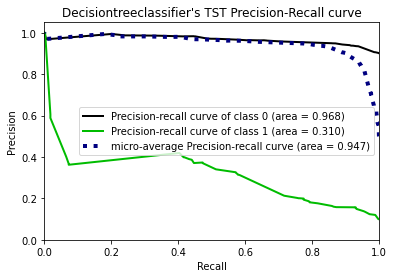

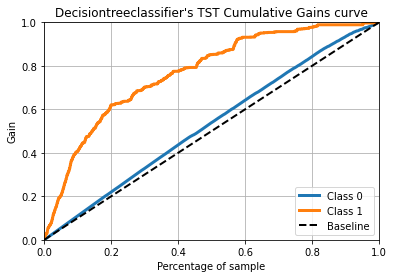

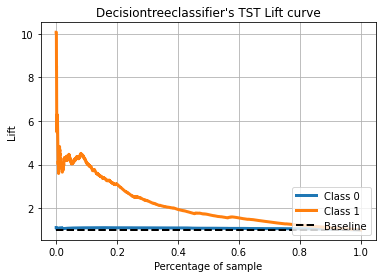

/home/alexandra/anaconda3/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:244: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


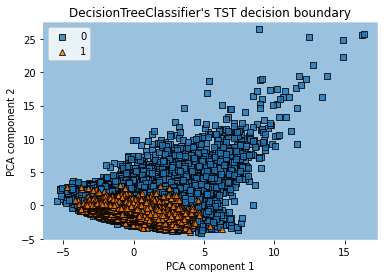

In [35]:
vt_tuned_model_tst, vt_y_pred_tst, vt_y_prob_tst = dt(
                                            X_tr=X_train_merged_vt, 
                                            y_tr=y_train_merged, 
                                            X_ts=X_test_vt, 
                                            y_ts=y_test, 
                                            grid=model_grid(X_train_merged_vt), 
                                            params=vt_params_tst, 
                                            v_or_t_flag='TST')

<h2>Learning curves </h2>

This plotting is done at the end of the notebook, beacuse for some reason yellowbrick library overwrite scikitplot.

In [36]:
from yellowbrick.model_selection import LearningCurve

def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

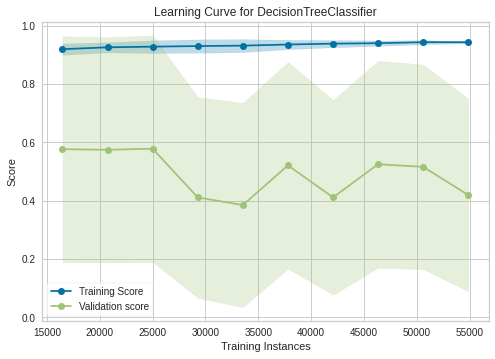

In [39]:
plot_learning_curve(X_train, 
                    y_train, 
                    rfe_tuned_model_val, 
                    'VAL')

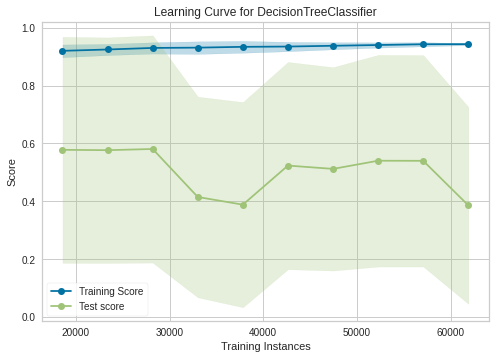

In [40]:
plot_learning_curve(X_train_merged, 
                    y_train_merged, 
                    rfe_tuned_model_val, 
                    'TST')